In [1]:
import os
import time
import torch
import json
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv
import segmentation_models_pytorch as smp

from pathlib import Path
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000                                                                                              
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from warmup_scheduler import GradualWarmupScheduler
from pytorch_toolbelt import losses as L

from src.metrics import get_jaccard_with_logits
from src.metrics import dice_with_logits
from src.data import FashionDataset

from src.utils import blend, MaskInfo
from src.utils import denormalize
from src.utils import custom_to_std_tensor
from src.utils import set_global_seed

from src.train import fit

/home/devel/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/devel/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/devel/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/devel/.local/lib/python3.6/site-packages/tensorboard/compat/tensorf

In [2]:
set_global_seed()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda', index=0)

In [5]:
data_folder = Path("input") 
train_folder = data_folder / "train"
test_folder = data_folder / "test"

logs_folder = Path("logs")
models_folder = Path("models")
splits_folder = Path("splits")

In [6]:
train_df = pd.read_csv(splits_folder / "train.csv")
test_df = pd.read_csv(splits_folder / "test.csv")
val_df = pd.read_csv(splits_folder / "val.csv")

with open(data_folder / "label_descriptions.json") as f:
    label_description = json.load(f)

In [7]:
batch_size = 3
num_workers = 10
train_num_samples=500
val_num_samples=100
test_num_samples=None

train_transforms = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(),    
    A.RandomBrightness(),
    A.RandomContrast(),
    custom_to_std_tensor
])


datasets = {}

datasets["train"] = FashionDataset(
    "train",
    train_df,
    train_folder,
    train_transforms,
    train_num_samples,
)

datasets["test"] = FashionDataset(
    "val",
    test_df,
    train_folder,
    A.Compose([
        A.Resize(512, 512),
        custom_to_std_tensor
    ]),
    test_num_samples,
)

datasets["val"] = FashionDataset(
    "val",
    val_df,
    train_folder,
    A.Compose([
        A.Resize(512, 512),
        custom_to_std_tensor
    ]),
    val_num_samples,
)


dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x], 
    batch_size=batch_size,
    num_workers=0,
    shuffle=True,
) for x in ["train", "test", "val"]}

loading time: 0.15367484092712402
torch.Size([3, 512, 512]) torch.Size([46, 512, 512])


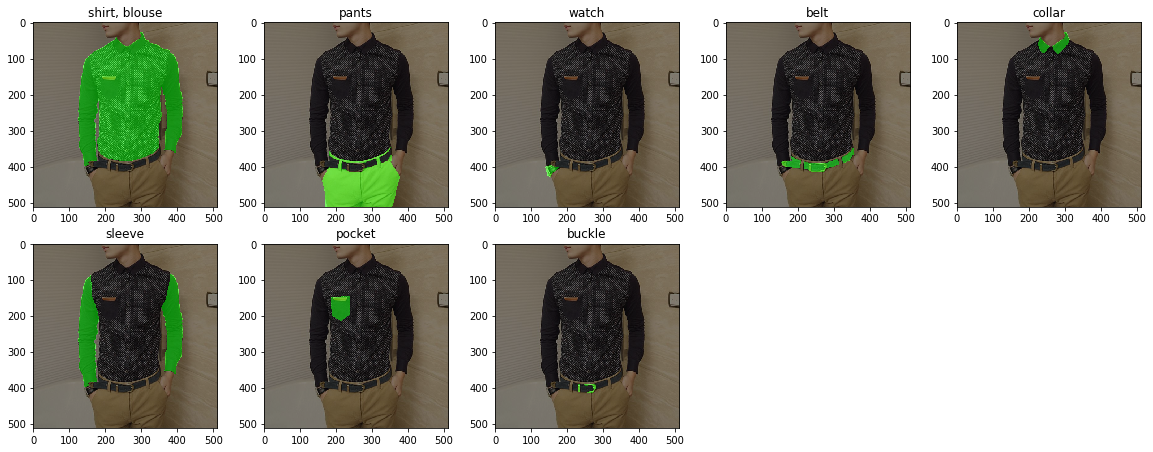

In [8]:
def draw(origin, masks, label_description):
    blends = {}
    for i, mask in enumerate(masks):
        if mask.bool().any():
            blends[label_description["categories"][i]["name"]] =\
            blend(denormalize(origin), MaskInfo(mask, g=1.0))

    plt.figure(figsize=(20, 40))
    for i, (name, img) in enumerate(blends.items()):
        plt.subplot(10, 5, i+1)
        plt.title(name)
        plt.imshow(img)


start_t = time.time()

name, image, mask = datasets["train"][17]


end_t = time.time()
print(f"loading time: {end_t - start_t}")

print(image.size(), mask.size())

draw(image, mask, label_description)

## Training

In [9]:
segmentation_model = smp.Unet(
    encoder_name="efficientnet-b2",
    encoder_weights="imagenet",
    classes=46,
    activation=None
)

In [14]:
lr = 0.001

criterion = L.BinaryFocalLoss()
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=5,
    factor=0.5,
    mode="max"
)

In [15]:
epochs = 100
initial_epoch = 0
accumulation_steps = 8
model_name = "unet-efficientnet-b2-v0"

writer_folder = (logs_folder / model_name)
if not writer_folder.exists():
    writer_folder.mkdir()
writer = SummaryWriter(writer_folder)

In [16]:
checkpoint_fn = models_folder / "unet-efficientnet-b2-v0-epoch-0-ckpt.pt"

if checkpoint_fn is not None:
    checkpoint = torch.load(checkpoint_fn, map_location=torch.device("cpu"))

    if "model_state_dict" in checkpoint:
        segmentation_model.load_state_dict(checkpoint["model_state_dict"])
        print("load model_state_dict")
    else:
        segmentation_model.load_state_dict(checkpoint)
        print("load model checkpoint")

    if "epoch" in checkpoint:
        initial_epoch = checkpoint["epoch"]
        print("load initial epoch")

load model_state_dict
load initial epoch


In [17]:
segmentation_model.to(device)
segmentation_model.train();

In [18]:
fit(
    segmentation_model,
    device,
    criterion, 
    optimizer,
    scheduler,
    dataloaders,
    metrics={
        "dice": dice_with_logits,
    },
    metrics_monitor="dice",
    metrics_lower_is_better=False,
    writer=writer,
    writer_add_visualizations=False,
    model_folder=models_folder,
    model_name=model_name,
    remove_previous_ckpt=True,
    epochs=epochs,
    initial_epoch=initial_epoch,
    accumulation_steps=accumulation_steps,
)


epoch: 1/100, time: 790.8390352725983, train loss: 0.09180287355184555, 
val loss: 0.07702430434525014, val_metric: 0.021661148867569865
checkpoint saved




epoch: 2/100, time: 780.1312181949615, train loss: 0.06978945921361446, 
val loss: 0.06418553568422794, val_metric: 0.18409268476068974
checkpoint saved




epoch: 3/100, time: 741.8399674892426, train loss: 0.05838722713291645, 
val loss: 0.053253031149506566, val_metric: 0.2389294157922268
checkpoint saved




epoch: 4/100, time: 934.1405990123749, train loss: 0.04846999958157539, 
val loss: 0.04421171046793461, val_metric: 0.2692020630836487
checkpoint saved




epoch: 5/100, time: 870.2473576068878, train loss: 0.039533086463809014, 
val loss: 0.03617044711485505, val_metric: 0.3323755030333996
checkpoint saved




epoch: 6/100, time: 838.8762984275818, train loss: 0.032060810443013905, 
val loss: 0.030635007899254562, val_metric: 0.44153324633836744
checkpoint saved




epoch: 7/100, time: 789.0723009109497, train loss: 0.026302780404686928, 
val loss: 0.025288370568305255, val_metric: 0.47847173288464545
checkpoint saved




epoch: 8/100, time: 910.2445509433746, train loss: 0.021987624187022447, 
val loss: 0.021189695131033658, val_metric: 0.5490021553635597
checkpoint saved




epoch: 9/100, time: 821.9735870361328, train loss: 0.01841771725192666, 
val loss: 0.01800038601271808, val_metric: 0.6558428511023522
checkpoint saved




epoch: 10/100, time: 846.5793092250824, train loss: 0.015704541984945537, 
val loss: 0.015075052436441184, val_metric: 0.743078930079937
checkpoint saved




epoch: 11/100, time: 804.8662054538727, train loss: 0.013730359168723226, 
val loss: 0.013220463525503873, val_metric: 0.7487374383211136
checkpoint saved




epoch: 12/100, time: 802.232985496521, train loss: 0.01183610538393259, 
val loss: 0.011022346885874867, val_metric: 0.77131975710392
checkpoint saved




epoch: 13/100, time: 767.1549634933472, train loss: 0.010308897234499454, 
val loss: 0.01007831044960767, val_metric: 0.8030520224571228
checkpoint saved




epoch: 14/100, time: 893.6761498451233, train loss: 0.009388959989883006, 
val loss: 0.008589389049448073, val_metric: 0.8141307330131531
checkpoint saved




epoch: 15/100, time: 747.585257768631, train loss: 0.008053501524031162, 
val loss: 0.007926931502297521, val_metric: 0.8215229690074921
checkpoint saved



KeyboardInterrupt: 

## Sandbox

In [21]:
from src.metrics import dice, dice_single_channel

In [163]:
name, image, mask = datasets["val"][99]

images = image.unsqueeze(0)
masks = mask.unsqueeze(0)
images = images.cuda()
masks = masks.cuda()


with torch.no_grad():
    segmentation_model.eval()
    outs = segmentation_model(images)
    outs = outs.cpu().detach()

probs = outs.sigmoid()

dice(masks.cpu(), probs.cpu() > 0.5)

tensor(0.8261)

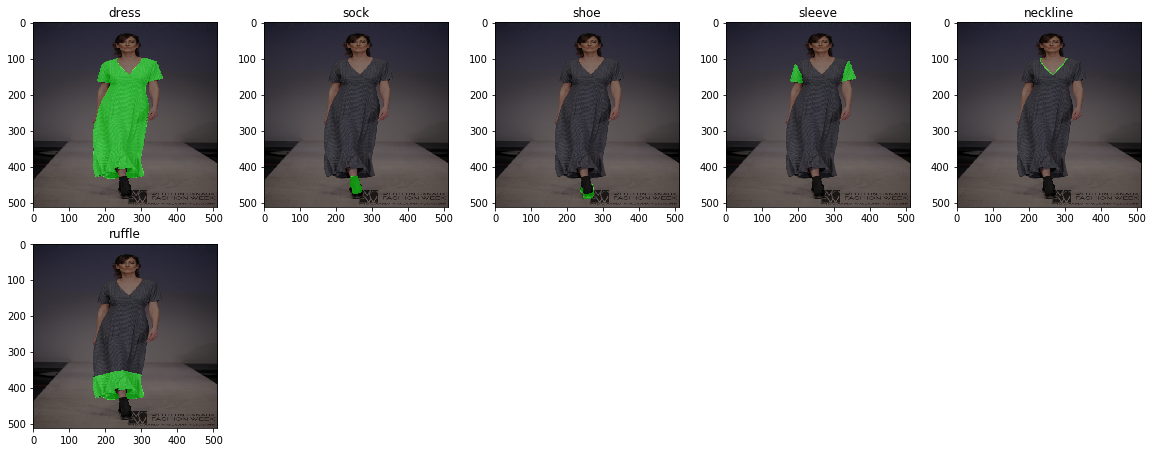

In [164]:
draw(images[0].cpu(), masks[0].cpu(), label_description)

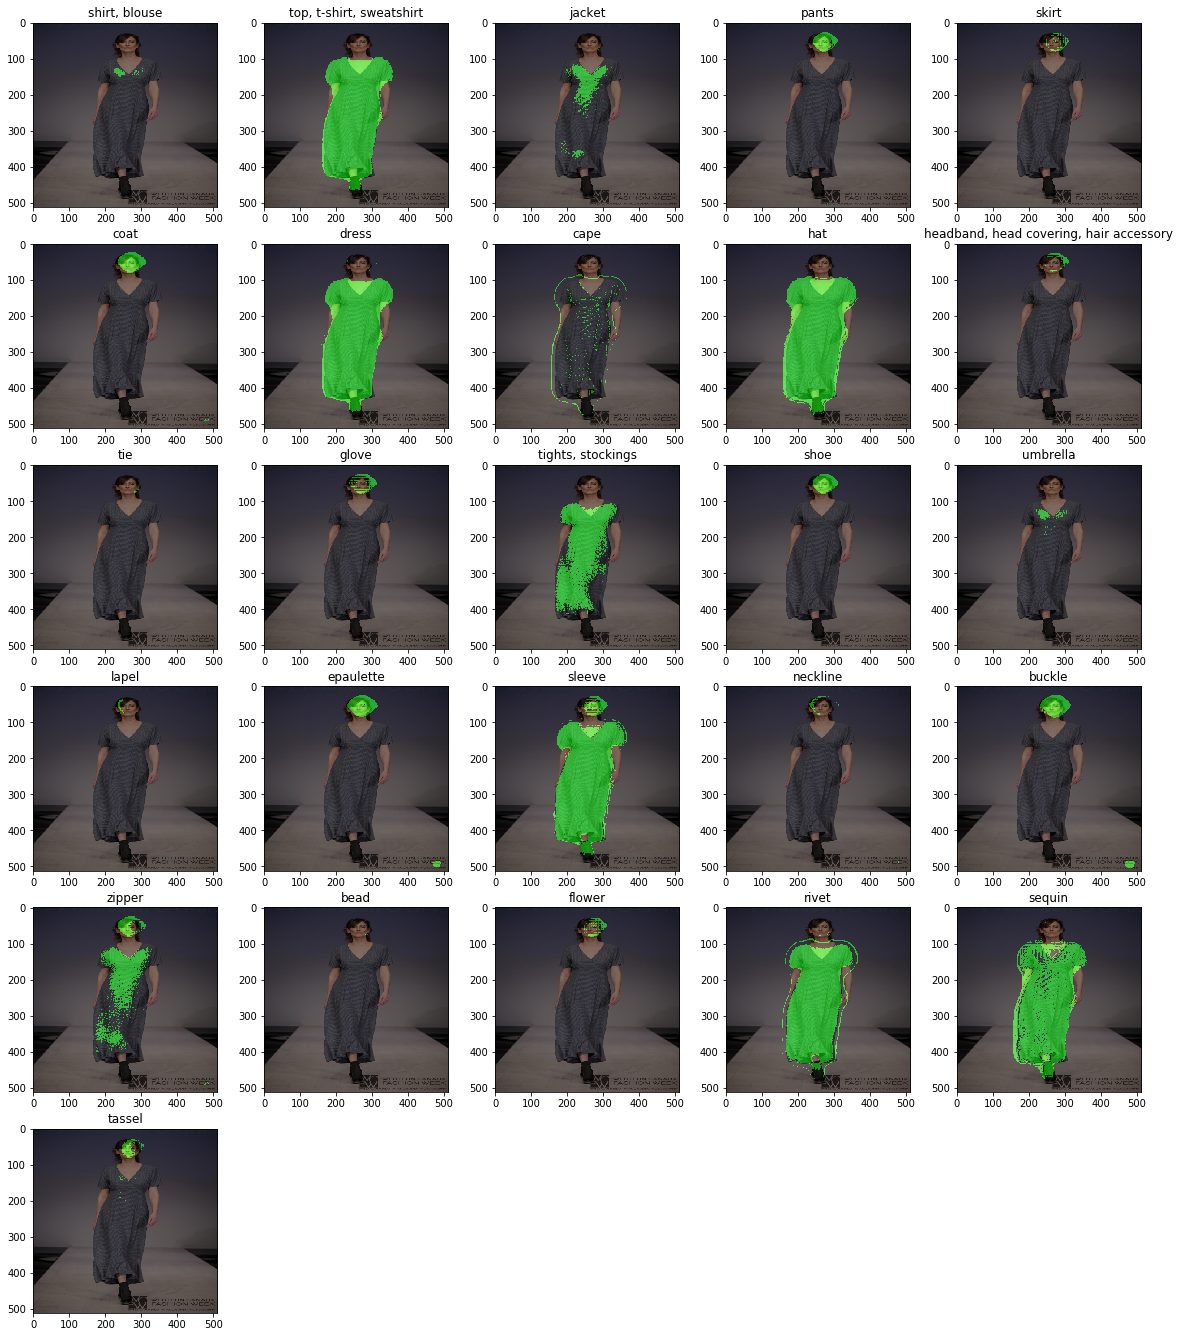

In [170]:
draw(images[0].cpu(), probs[0].cpu() > 0.3, label_description)
plt.savefig("images/sample-2.png", bbox_inches="tight")